# Monthly Spending — EDA & Modeling 

**Course:** CS 3120 Machine Learning 
**Author:** Casillas, Alejandro 
**Dataset:** Monthly Spending for EDA  

In [49]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

pd.set_option('display.max_columns', 100)
sns.set_theme()
import kagglehub

path = kagglehub.dataset_download("rajatkhairnar/monthly-spending-for-eda")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/monthly-spending-for-eda


## 1) Load Data

In [50]:
def find_csv_paths():
    candidates = []
    for root, dirs, files in os.walk( '/kaggle/input/monthly-spending-for-eda/' ):
        for f in files:
            if f.lower().endswith('.csv'):
                candidates.append(os.path.join(root, f))
    # Also search current dir in case running locally
    for f in glob.glob('*.csv'):
        candidates.append(os.path.abspath(f))
    return candidates

csvs = find_csv_paths()
if not csvs:
    raise FileNotFoundError('No CSV files found. Upload the dataset or add it via Kaggle Datasets.')

csv_path = csvs[0]
print('Using CSV:', csv_path)
df = pd.read_csv(csv_path)
print('Shape:', df.shape)

INR_PER_USD = 83  # exchange rate

# Detect all rupee columns automatically (they contain the ₹ symbol)
rupee_cols = [c for c in df.columns if '₹' in c]

# Convert values in-place from rupees → dollars
df[rupee_cols] = df[rupee_cols] / INR_PER_USD

# Rename columns to show dollars instead of rupees
df.rename(columns=lambda c: c.replace('(₹)', '($)'), inplace=True)

df.head()

Using CSV: /kaggle/input/monthly-spending-for-eda/monthly_spending_dataset_2020_2025.csv
Shape: (69, 14)


,Month,Groceries ($),Rent ($),Transportation ($),Gym ($),Utilities ($),Healthcare ($),Investments ($),Savings ($),EMI/Loans ($),Dining & Entertainment ($),Shopping & Wants ($),Total Expenditure ($),Income ($)
0,2020-01-01,58.554217,120.481928,31.265060,10.698795,18.313253,23.253012,51.939759,50.987952,0.0,37.807229,13.506024,365.819277,481.927711
1,2020-02-01,73.915663,120.481928,28.566265,10.253012,19.638554,23.168675,71.554217,88.301205,0.0,38.373494,28.096386,414.048193,481.927711
2,2020-03-01,82.566265,120.481928,32.710843,13.771084,21.397590,14.277108,56.626506,43.674699,0.0,32.337349,17.578313,391.746988,433.734940
3,2020-04-01,83.180723,120.481928,31.108434,10.469880,23.795181,15.349398,53.253012,77.421687,0.0,29.819277,33.807229,401.265060,433.734940
4,2020-05-01,54.963855,120.481928,36.481928,10.000000,23.903614,19.650602,53.132530,43.939759,0.0,25.855422,12.289157,356.759036,433.734940


## 2) Basic Cleaning & Schema

In [51]:
# Standardize column names
df.columns = [c.strip().replace(' ', '_') for c in df.columns]

# Try to identify date-like column
date_cols_guess = [c for c in df.columns if re.search(r'(date|month|year)', c, re.I)]
date_col = date_cols_guess[0] if date_cols_guess else None
if date_col is not None:
    try:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col)
    except Exception as e:
        print('Date parse warning:', e)

# Identify numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns detected:', num_cols)

# Basic info
display(df.head())
display(df.describe(include='all'))
df.isna().sum().sort_values(ascending=False).head(20)

Numeric columns detected: ['Groceries_($)', 'Rent_($)', 'Transportation_($)', 'Gym_($)', 'Utilities_($)', 'Healthcare_($)', 'Investments_($)', 'Savings_($)', 'EMI/Loans_($)', 'Dining_&_Entertainment_($)', 'Shopping_&_Wants_($)', 'Total_Expenditure_($)', 'Income_($)']


,Month,Groceries_($),Rent_($),Transportation_($),Gym_($),Utilities_($),Healthcare_($),Investments_($),Savings_($),EMI/Loans_($),Dining_&_Entertainment_($),Shopping_&_Wants_($),Total_Expenditure_($),Income_($)
0,2020-01-01,58.554217,120.481928,31.265060,10.698795,18.313253,23.253012,51.939759,50.987952,0.0,37.807229,13.506024,365.819277,481.927711
1,2020-02-01,73.915663,120.481928,28.566265,10.253012,19.638554,23.168675,71.554217,88.301205,0.0,38.373494,28.096386,414.048193,481.927711
2,2020-03-01,82.566265,120.481928,32.710843,13.771084,21.397590,14.277108,56.626506,43.674699,0.0,32.337349,17.578313,391.746988,433.734940
3,2020-04-01,83.180723,120.481928,31.108434,10.469880,23.795181,15.349398,53.253012,77.421687,0.0,29.819277,33.807229,401.265060,433.734940
4,2020-05-01,54.963855,120.481928,36.481928,10.000000,23.903614,19.650602,53.132530,43.939759,0.0,25.855422,12.289157,356.759036,433.734940


,Month,Groceries_($),Rent_($),Transportation_($),Gym_($),Utilities_($),Healthcare_($),Investments_($),Savings_($),EMI/Loans_($),Dining_&_Entertainment_($),Shopping_&_Wants_($),Total_Expenditure_($),Income_($)
count,69,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,2022-10-31 14:36:31.304347904,75.745940,132.530120,30.954950,11.659857,23.842151,21.089401,76.108434,91.717479,13.619696,33.007159,23.659682,442.217391,607.787672
min,2020-01-01 00:00:00,50.048193,120.481928,18.084337,8.433735,18.240964,10.084337,47.614458,43.674699,0.000000,18.084337,12.289157,346.879518,433.734940
25%,2021-06-01 00:00:00,62.144578,120.481928,25.240964,10.253012,20.277108,15.530120,62.180723,73.156627,0.000000,25.855422,17.710843,395.530120,520.481928
50%,2022-11-01 00:00:00,76.722892,120.481928,31.373494,12.060241,23.855422,19.698795,75.361446,88.301205,0.000000,33.048193,22.915663,410.975904,578.313253
75%,2024-04-01 00:00:00,83.506024,156.626506,36.566265,13.060241,26.987952,24.915663,85.409639,113.614458,0.000000,38.373494,28.542169,490.024096,771.084337
max,2025-09-01 00:00:00,108.228916,156.626506,41.951807,14.409639,29.771084,35.638554,114.409639,145.469880,72.289157,48.084337,35.915663,592.373494,771.084337
std,NaN,14.859402,17.163545,6.960294,1.801308,3.670943,6.952749,17.582743,27.195984,28.474745,8.187116,6.965383,70.406455,123.719881


Month                         0
Groceries_($)                 0
Rent_($)                      0
Transportation_($)            0
Gym_($)                       0
Utilities_($)                 0
Healthcare_($)                0
Investments_($)               0
Savings_($)                   0
EMI/Loans_($)                 0
Dining_&_Entertainment_($)    0
Shopping_&_Wants_($)          0
Total_Expenditure_($)         0
Income_($)                    0
dtype: int64

### Handle Missing Values

In [52]:
# Simple strategy: fill numeric NaNs with column medians
df[num_cols] = df[num_cols].apply(lambda col: col.fillna(col.median()))
if date_col is not None and df[date_col].isna().any():
    df[date_col] = df[date_col].fillna(method='ffill').fillna(method='bfill')
df.isna().sum().sum()

0

### Target Definition (Total Spending)

In [53]:
# Try to detect an existing total column
possible_total_names = ['Total', 'Total_Spending', 'TotalSpending', 'Total_Expense', 'Total_Expenses']
total_col = None
for name in possible_total_names:
    if name in df.columns:
        total_col = name
        break

# If not present, estimate total as sum of expense-like columns (exclude income/savings)
if total_col is None:
    expense_like = [c for c in num_cols if not re.search(r'(income|saving|savings|balance)', c, re.I)]
    # If date converted to integer timestamp, exclude from expense-like
    if date_col is not None and date_col in expense_like:
        expense_like.remove(date_col)
    df['Total_Spending_Est'] = df[expense_like].sum(axis=1)
    total_col = 'Total_Spending_Est'

print('Using target column:', total_col)
df[total_col].describe()

Using target column: Total_Spending_Est


count      69.000000
mean      884.434783
std       140.812910
min       693.759036
25%       791.060241
50%       821.951807
75%       980.048193
max      1184.746988
Name: Total_Spending_Est, dtype: float64

## 3) Exploratory Data Analysis (EDA)

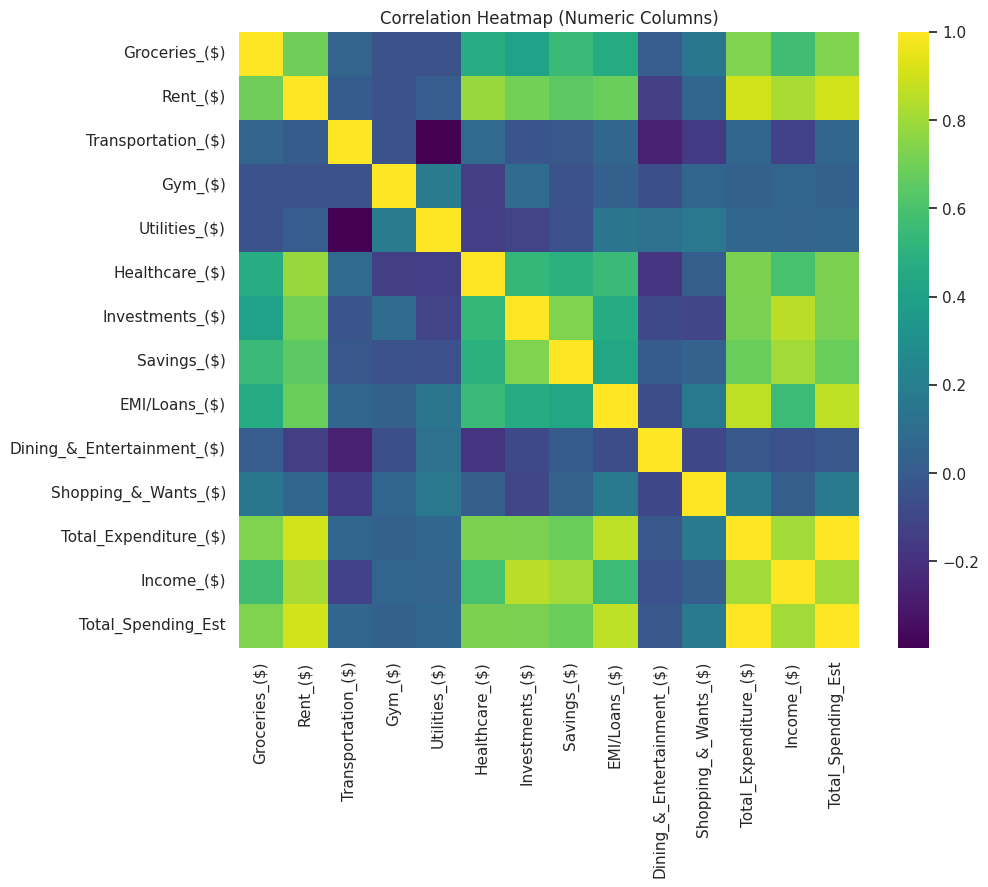

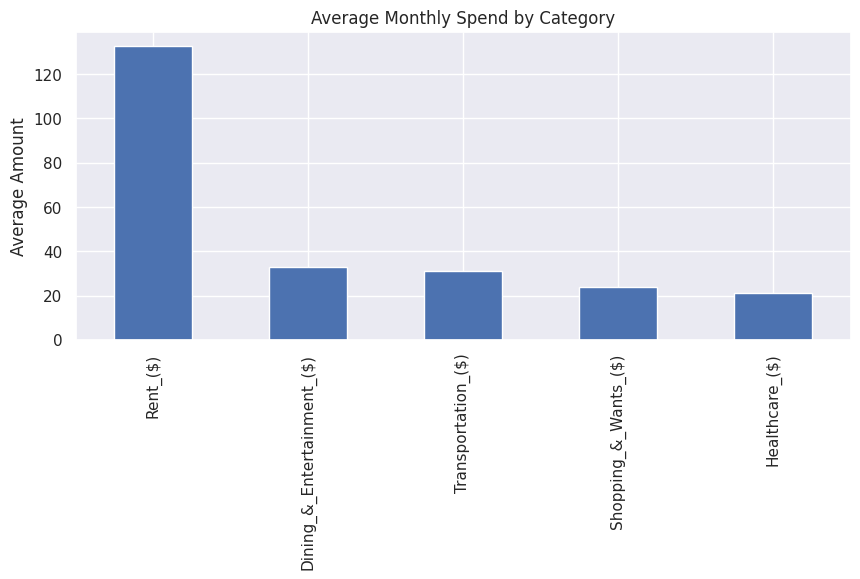

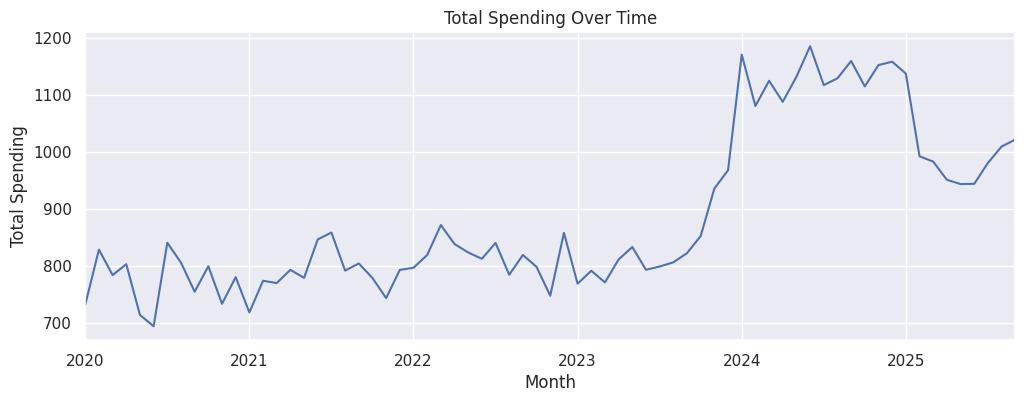

In [54]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes('number').corr(), annot=False, cmap='viridis')
plt.title('Correlation Heatmap (Numeric Columns)')
plt.show()

# Category shares (if common expense columns are present)
common_expenses = [c for c in df.columns if re.search(r'(rent|food|entertain|transport|utility|shop|health)', c, re.I)]
if common_expenses:
    shares = df[common_expenses].mean().sort_values(ascending=False)
    shares.plot(kind='bar', figsize=(10,4), title='Average Monthly Spend by Category')
    plt.ylabel('Average Amount')
    plt.show()

# Time series of total spending
if date_col is not None:
    ts = df[[date_col, total_col]].dropna().sort_values(date_col)
    ts.set_index(date_col)[total_col].plot(figsize=(12,4), title='Total Spending Over Time')
    plt.ylabel('Total Spending')
    plt.show()

## 4) Feature Engineering & Split

In [55]:
# Features: all numeric columns except the target
numeric = df.select_dtypes(include=[np.number])
X = numeric.drop(columns=[total_col], errors='ignore')
y = numeric[total_col]

# Basic train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((55, 13), (14, 13))

## 5) Baseline Model — Linear Regression

In [56]:
lin = LinearRegression()
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)

r2_lin = r2_score(y_test, pred_lin)
mae_lin = mean_absolute_error(y_test, pred_lin)
rmse_lin = mean_squared_error(y_test, pred_lin, squared=False)

print({'R2': r2_lin, 'MAE': mae_lin, 'RMSE': rmse_lin})

{'R2': 1.0, 'MAE': 8.851332365468676e-13, 'RMSE': 9.613094405999484e-13}


## 6) Advanced Model — Random Forest Regressor

{'R2': 0.9603797269122429, 'MAE': 23.029493975904114, 'RMSE': 30.460366571135403}


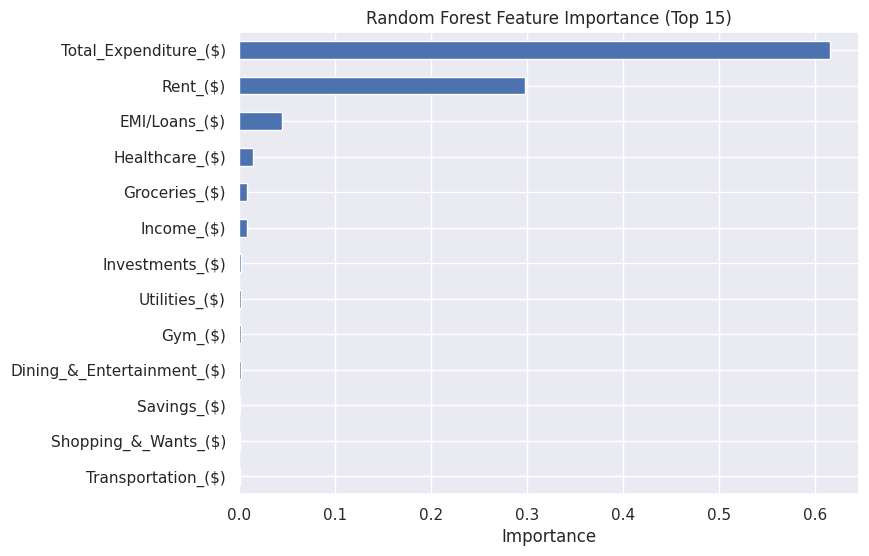

In [57]:
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, pred_rf)
mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = mean_squared_error(y_test, pred_rf, squared=False)

print({'R2': r2_rf, 'MAE': mae_rf, 'RMSE': rmse_rf})

# Feature importance plot (if available)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:15]
importances.plot(kind='barh', figsize=(8,6), title='Random Forest Feature Importance (Top 15)')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.show()

## 7) Model Comparison

In [58]:
results = pd.DataFrame([
    {'Model':'Linear Regression','R2': r2_lin, 'MAE': mae_lin, 'RMSE': rmse_lin},
    {'Model':'Random Forest','R2': r2_rf, 'MAE': mae_rf, 'RMSE': rmse_rf}
])
display(results)

best = results.sort_values('RMSE').iloc[0]
print('Best model by RMSE:', best['Model'])

,Model,R2,MAE,RMSE
0,Linear Regression,1.00000,8.851332e-13,9.613094e-13
1,Random Forest,0.96038,2.302949e+01,3.046037e+01


Best model by RMSE: Linear Regression


## 8) Save Results Summary

In [59]:
summary_path = 'model_results_summary.csv'
results.to_csv(summary_path, index=False)
print('Saved:', summary_path)

Saved: model_results_summary.csv


**Metrics used:**
- **R² (Coefficient of Determination):** higher is better (explained variance).
- **MAE (Mean Absolute Error):** average error magnitude; lower is better.
- **RMSE (Root Mean Squared Error):** penalizes large errors; lower is better.